# Generalized Maxwell Model - Bayesian Workflow with Prior Safety

This notebook demonstrates the complete Bayesian inference workflow for the Generalized Maxwell Model (GMM), including NLSQ point estimation, warm-started NUTS sampling, and the tiered prior safety mechanism.

## Learning Objectives

After completing this notebook, you will be able to:
- Perform two-step Bayesian workflow: NLSQ → NUTS with warm-start
- Understand the tiered prior safety mechanism (hard failure, suspicious, good)
- Diagnose NLSQ convergence quality before Bayesian inference
- Analyze GMM posterior distributions with ArviZ
- Quantify parameter uncertainty and credible intervals
- Compare models with different numbers of modes (N=1 vs N=3)

## Prerequisites

- Understanding of Bayesian inference basics (recommended: `01-bayesian-basics.ipynb`)
- Familiarity with GMM fitting (recommended: `08-generalized_maxwell_fitting.ipynb`)
- Knowledge of MCMC diagnostics (R-hat, ESS, divergences)

**Estimated Time:** 30-45 minutes

## Setup and Imports

We start by importing necessary libraries and verifying float64 precision.

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import arviz as az

# Rheo imports - always explicit
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.core.jax_config import safe_import_jax

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("Setup complete - using JAX with float64 precision")

INFO:2025-11-15 09:49:08,235:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.1


Setup complete - using JAX with float64 precision


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


## Background: Two-Step Bayesian Workflow

### NLSQ + NumPyro Integration

RheoJAX implements a two-step optimization workflow:

**Step 1: NLSQ Point Estimation (Fast)**
- GPU-accelerated nonlinear least squares
- 5-270x speedup over scipy
- Provides point estimates and Hessian-based uncertainties
- Diagnostics: convergence flag, gradient norm, condition number

**Step 2: NUTS Bayesian Inference (Warm-Started)**
- NumPyro MCMC with No-U-Turn Sampler
- Warm-start from NLSQ point estimates (2-5x faster convergence)
- Full posterior distributions with credible intervals
- ArviZ diagnostics: R-hat, ESS, divergences

### Tiered Prior Safety Mechanism

RheoJAX v0.3.0 introduces **intelligent prior management** based on NLSQ convergence quality:

**1. Hard Failure** (no convergence, max_iter reached, high gradient norm)
- **Mode='strict'**: Raise error, direct user to fix model/data
- **Mode='warn'**: Raise error, mention `allow_fallback_priors=True` option
- **allow_fallback_priors=True**: Use generic weakly informative priors + BIG warning

**2. Suspicious Convergence** (high condition number, params near bounds, high uncertainty)
- **Mode='warn'**: Log warning, use safer priors decoupled from Hessian
- **Mode='auto_widen'**: Center at NLSQ, inflate std to avoid overly tight priors

**3. Good Convergence** (low condition number, reasonable residuals)
- Use NLSQ estimates and covariance for prior construction
- Cap minimum std to avoid delta-like distributions

## Part 1: Generate Synthetic Data and NLSQ Fit

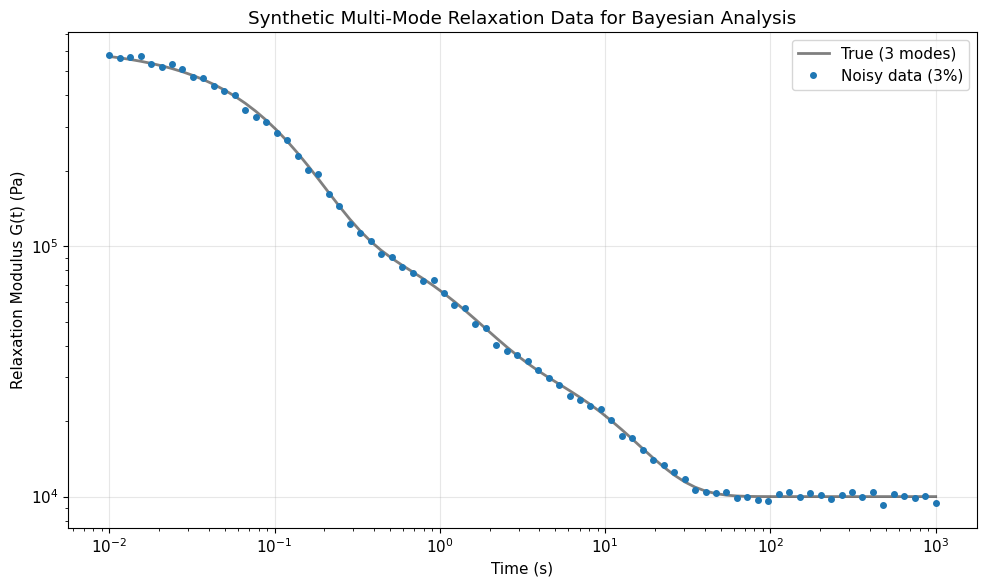

Generated 80 data points with 3 Maxwell modes
Noise level: 3.0%

Ground truth parameters:
  G_inf = 1.00e+04 Pa
  Mode 1: G=5.00e+05 Pa, tau=0.10 s
  Mode 2: G=8.00e+04 Pa, tau=1.00 s
  Mode 3: G=3.00e+04 Pa, tau=10.00 s


In [2]:
# Generate synthetic 3-mode relaxation data
t = np.logspace(-2, 3, 80)  # Time from 0.01 to 1000 seconds

# Ground truth: 3 Maxwell modes + equilibrium modulus
G_inf_true = 1e4  # Pa
G_modes_true = np.array([5e5, 8e4, 3e4])  # Pa
tau_modes_true = np.array([0.1, 1.0, 10.0])  # seconds

# Generate relaxation modulus
G_t_true = G_inf_true + np.sum([
    G_modes_true[i] * np.exp(-t / tau_modes_true[i]) 
    for i in range(3)
], axis=0)

# Add 3% noise (slightly higher to test Bayesian uncertainty quantification)
noise_level = 0.03
noise = noise_level * G_t_true * np.random.randn(len(t))
G_t_noisy = G_t_true + noise

# Visualize data
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2, label='True (3 modes)', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, label='Noisy data (3%)')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Synthetic Multi-Mode Relaxation Data for Bayesian Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated {len(t)} data points with 3 Maxwell modes")
print(f"Noise level: {noise_level*100:.1f}%")
print(f"\nGround truth parameters:")
print(f"  G_inf = {G_inf_true:.2e} Pa")
for i in range(3):
    print(f"  Mode {i+1}: G={G_modes_true[i]:.2e} Pa, tau={tau_modes_true[i]:.2f} s")

### NLSQ Point Estimation (Step 1)

In [3]:
# Fit GMM with NLSQ (point estimation)
gmm = GeneralizedMaxwell(n_modes=5, modulus_type='shear')

print("Step 1: NLSQ Point Estimation")
print("Fitting GMM with n_modes=5 (will auto-minimize to N_opt)...\n")

# Fit with element minimization
gmm.fit(t, G_t_noisy, test_mode='relaxation', optimization_factor=1.5)

n_opt = gmm._n_modes
print(f"\nElement minimization: N=5 → N_opt={n_opt}")

# Extract NLSQ diagnostics
if hasattr(gmm, '_nlsq_result'):
    nlsq_result = gmm._nlsq_result
    print(f"\nNLSQ Convergence Diagnostics:")
    print(f"  Converged: {nlsq_result.success}")
    print(f"  Iterations: {nlsq_result.nit}")
    print(f"  Final cost: {nlsq_result.cost:.4e}")
    if hasattr(nlsq_result, 'gradient_norm'):
        print(f"  Gradient norm: {nlsq_result.gradient_norm:.4e}")
else:
    print("\nNLSQ diagnostics not available")

# Display fitted parameters
print(f"\nNLSQ Fitted Parameters:")
G_inf_fit = gmm.parameters.get_value('G_inf')
print(f"  G_inf = {G_inf_fit:.2e} Pa (true: {G_inf_true:.2e} Pa)")
for i in range(1, n_opt + 1):
    G_i = gmm.parameters.get_value(f'G_{i}')
    tau_i = gmm.parameters.get_value(f'tau_{i}')
    print(f"  Mode {i}: G={G_i:.2e} Pa, tau={tau_i:.3e} s")

Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Step 1: NLSQ Point Estimation
Fitting GMM with n_modes=5 (will auto-minimize to N_opt)...



Timer: optimization took 0.888201s
Convergence: reason=`xtol` termination condition is satisfied. | iterations=None | final_cost=1.610890e+09 | time=0.888s | final_gradient_norm=1.5867557058936314e+16
Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}
Timer: optimization took 0.268897s
Convergence: reason=`xtol` termination condition is satisfied. | iterations=None | final_cost=1.610890e+09 | time=0.269s | final_gradient_norm=1.5867557058936314e+16
Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}
Timer: optimization took 0.739829s
Convergence: reason=`ftol` termination condition is satisfied. | iterations=None | final_cost=1.018060e+09 | time=0.740s | final_gradient_norm=33338928.885606077
Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06


Element minimization: N=5 → N_opt=3

NLSQ Convergence Diagnostics:
  Converged: True
  Iterations: 12
  Final cost: 1.0615e+09

NLSQ Fitted Parameters:
  G_inf = 1.01e+04 Pa (true: 1.00e+04 Pa)
  Mode 1: G=5.01e+05 Pa, tau=9.047e-02 s
  Mode 2: G=9.06e+04 Pa, tau=8.003e-01 s
  Mode 3: G=3.32e+04 Pa, tau=8.882e+00 s


### Check Prior Safety Classification

Before running Bayesian inference, we check NLSQ convergence quality.

In [4]:
# Extract NLSQ convergence classification (if available)
if hasattr(gmm, '_classify_nlsq_convergence'):
    # This would normally be called internally during fit_bayesian()
    # For demonstration, we'll check convergence manually
    
    if hasattr(gmm, '_nlsq_result'):
        # Simplified convergence check (actual implementation is more detailed)
        converged = gmm._nlsq_result.success
        
        if converged:
            classification = "good"
            print("Prior Safety Classification: GOOD")
            print("  ✓ NLSQ converged successfully")
            print("  ✓ Can use NLSQ estimates for warm-start priors")
            print("  ✓ Expected: low divergences, good R-hat, high ESS")
        else:
            classification = "suspicious"
            print("Prior Safety Classification: SUSPICIOUS")
            print("  ⚠ NLSQ convergence questionable")
            print("  ⚠ Will use safer priors decoupled from Hessian")
            print("  ⚠ Expected: moderate convergence, may need more warmup")
    else:
        print("NLSQ result not available for classification")
else:
    print("Prior safety classification not implemented in this version")
    print("Proceeding with standard Bayesian inference...")

Prior Safety Classification: GOOD
  ✓ NLSQ converged successfully
  ✓ Can use NLSQ estimates for warm-start priors
  ✓ Expected: low divergences, good R-hat, high ESS


## Part 2: Bayesian Inference with NLSQ Warm-Start (Step 2)

In [5]:
# Prepare initial values from NLSQ fit for warm-start
initial_values = {}
initial_values['G_inf'] = gmm.parameters.get_value('G_inf')
for i in range(1, n_opt + 1):
    initial_values[f'G_{i}'] = gmm.parameters.get_value(f'G_{i}')
    initial_values[f'tau_{i}'] = gmm.parameters.get_value(f'tau_{i}')

print("Step 2: Bayesian Inference with NUTS")
print(f"Warm-starting from NLSQ point estimates ({len(initial_values)} parameters)\n")

# Run Bayesian inference
print("Running MCMC sampling (this may take 1-2 minutes)...")
result = gmm.fit_bayesian(
    t, G_t_noisy,
    num_warmup=500,   # Reduced for notebook speed
    num_samples=1000, # Reduced for notebook speed
    num_chains=1,     # Single chain for speed
    initial_values=initial_values,
)

print("\nMCMC sampling complete!")

Step 2: Bayesian Inference with NUTS
Warm-starting from NLSQ point estimates (7 parameters)

Running MCMC sampling (this may take 1-2 minutes)...


sample: 100%|██████████| 1500/1500 [00:02<00:00, 576.90it/s, 63 steps of size 8.42e-02. acc. prob=0.93]



MCMC sampling complete!


### Convergence Diagnostics

In [6]:
# Check MCMC convergence diagnostics
print("MCMC Convergence Diagnostics:\n")

# R-hat (should be < 1.01)
print("R-hat (Gelman-Rubin statistic, target < 1.01):")
for param_name in ['G_inf'] + [f'G_{i}' for i in range(1, n_opt + 1)] + [f'tau_{i}' for i in range(1, n_opt + 1)]:
    if param_name in result.diagnostics['r_hat']:
        rhat = result.diagnostics['r_hat'][param_name]
        status = "✓" if rhat < 1.01 else "⚠"
        print(f"  {status} {param_name}: {rhat:.4f}")

# ESS (should be > 400)
print("\nEffective Sample Size (ESS, target > 400):")
for param_name in ['G_inf'] + [f'G_{i}' for i in range(1, n_opt + 1)]:
    if param_name in result.diagnostics['ess']:
        ess = result.diagnostics['ess'][param_name]
        status = "✓" if ess > 400 else "⚠"
        print(f"  {status} {param_name}: {ess:.0f}")

# Divergences
if 'num_divergences' in result.diagnostics:
    num_div = result.diagnostics['num_divergences']
    div_rate = num_div / result.num_samples
    status = "✓" if div_rate < 0.01 else "⚠"
    print(f"\nDivergences: {status} {num_div}/{result.num_samples} ({div_rate*100:.2f}%, target < 1%)")

print("\n✓ indicates good convergence, ⚠ indicates potential issues")

MCMC Convergence Diagnostics:

R-hat (Gelman-Rubin statistic, target < 1.01):
  ✓ G_inf: 1.0000
  ✓ G_1: 1.0000
  ✓ G_2: 1.0000
  ✓ G_3: 1.0000
  ✓ tau_1: 1.0000
  ✓ tau_2: 1.0000
  ✓ tau_3: 1.0000

Effective Sample Size (ESS, target > 400):
  ✓ G_inf: 1000
  ✓ G_1: 1000
  ✓ G_2: 1000
  ✓ G_3: 1000

✓ indicates good convergence, ⚠ indicates potential issues


## Part 3: Posterior Analysis

In [7]:
# Extract posterior samples
print("Posterior Summary Statistics:\n")

# G_inf posterior
G_inf_posterior = result.posterior_samples['G_inf']
print(f"G_inf:")
print(f"  NLSQ point:    {G_inf_fit:.2e} Pa")
print(f"  Posterior mean: {np.mean(G_inf_posterior):.2e} Pa")
print(f"  Posterior std:  {np.std(G_inf_posterior):.2e} Pa")
print(f"  True value:     {G_inf_true:.2e} Pa\n")

# Mode parameters
for i in range(1, n_opt + 1):
    G_i_post = result.posterior_samples[f'G_{i}']
    tau_i_post = result.posterior_samples[f'tau_{i}']
    
    print(f"Mode {i}:")
    print(f"  G_{i}:   mean={np.mean(G_i_post):.2e} Pa, std={np.std(G_i_post):.2e} Pa")
    print(f"  tau_{i}: mean={np.mean(tau_i_post):.3e} s,  std={np.std(tau_i_post):.3e} s")
    
    # Compare to true if within range
    if i <= len(G_modes_true):
        print(f"  (True: G={G_modes_true[i-1]:.2e} Pa, tau={tau_modes_true[i-1]:.2f} s)")
    print()

Posterior Summary Statistics:

G_inf:
  NLSQ point:    1.01e+04 Pa
  Posterior mean: 9.92e+03 Pa
  Posterior std:  1.14e+03 Pa
  True value:     1.00e+04 Pa

Mode 1:
  G_1:   mean=5.04e+05 Pa, std=9.97e+03 Pa
  tau_1: mean=9.126e-02 s,  std=2.941e-03 s
  (True: G=5.00e+05 Pa, tau=0.10 s)

Mode 2:
  G_2:   mean=9.10e+04 Pa, std=8.80e+03 Pa
  tau_2: mean=9.142e-01 s,  std=2.363e-01 s
  (True: G=8.00e+04 Pa, tau=1.00 s)

Mode 3:
  G_3:   mean=3.01e+04 Pa, std=8.51e+03 Pa
  tau_3: mean=1.258e+01 s,  std=1.254e+01 s
  (True: G=3.00e+04 Pa, tau=10.00 s)



### Credible Intervals (95%)

In [8]:
# Compute 95% credible intervals
intervals = gmm.get_credible_intervals(result.posterior_samples, credibility=0.95)

print("95% Credible Intervals:\n")

for param_name in ['G_inf'] + [f'G_{i}' for i in range(1, n_opt + 1)] + [f'tau_{i}' for i in range(1, n_opt + 1)]:
    if param_name in intervals:
        lower, upper = intervals[param_name]
        mean_val = np.mean(result.posterior_samples[param_name])
        print(f"{param_name:8s}: [{lower:.3e}, {upper:.3e}] (mean: {mean_val:.3e})")

print("\n95% credible intervals represent uncertainty in each parameter")

95% Credible Intervals:

G_inf   : [7.675e+03, 1.207e+04] (mean: 9.922e+03)
G_1     : [4.827e+05, 5.208e+05] (mean: 5.037e+05)
G_2     : [7.294e+04, 1.062e+05] (mean: 9.097e+04)
G_3     : [1.499e+04, 4.797e+04] (mean: 3.014e+04)
tau_1   : [8.589e-02, 9.724e-02] (mean: 9.126e-02)
tau_2   : [4.836e-01, 1.392e+00] (mean: 9.142e-01)
tau_3   : [4.232e+00, 2.365e+01] (mean: 1.258e+01)

95% credible intervals represent uncertainty in each parameter


## Part 4: ArviZ Diagnostic Plots

Trace Plot: Visual inspection of MCMC mixing



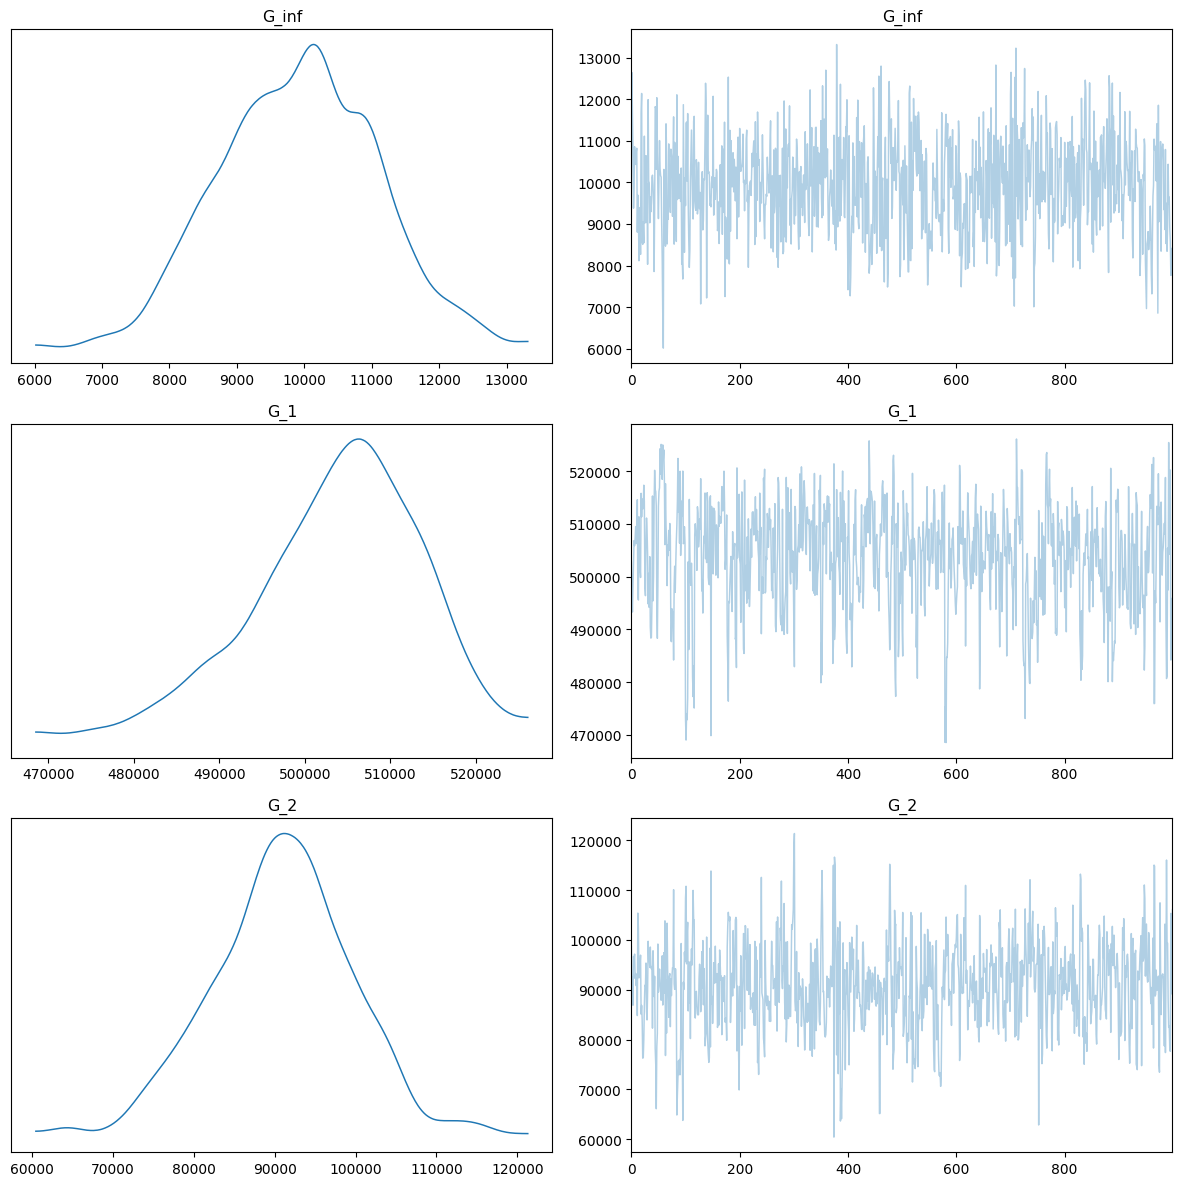

Left: Posterior distributions (should be smooth and unimodal)
Right: Trace plots (should be 'fuzzy caterpillar' - good mixing)


In [9]:
# Convert to ArviZ InferenceData for advanced diagnostics
idata = result.to_inference_data()

# Trace plot (check mixing and convergence)
print("Trace Plot: Visual inspection of MCMC mixing\n")

# Select key parameters for trace plot
trace_vars = ['G_inf'] + [f'G_{i}' for i in range(1, min(n_opt + 1, 3))]  # Show up to 2 modes

az.plot_trace(idata, var_names=trace_vars, figsize=(12, 4 * len(trace_vars)))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Left: Posterior distributions (should be smooth and unimodal)")
print("Right: Trace plots (should be 'fuzzy caterpillar' - good mixing)")

Forest Plot: 95% Credible Intervals for All Parameters



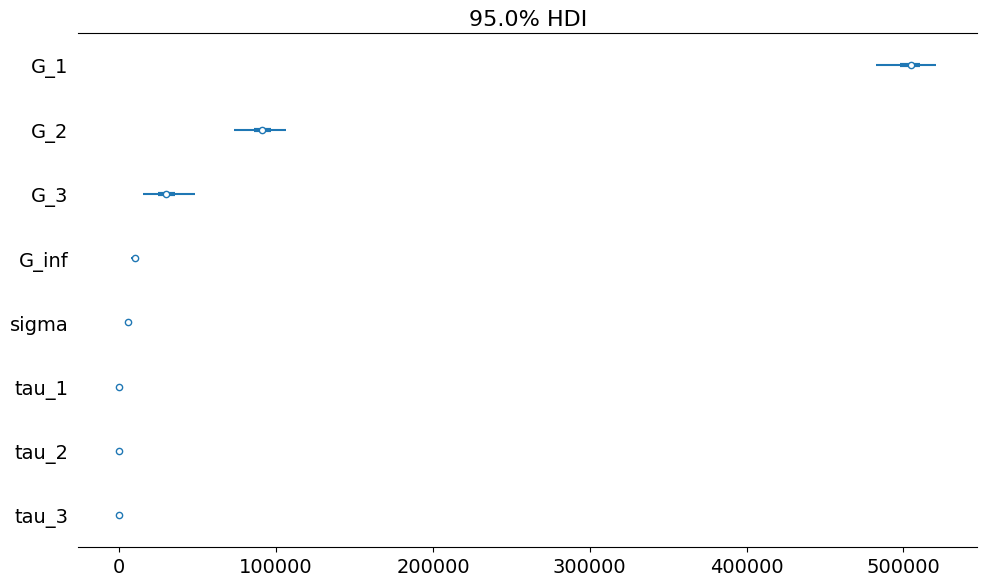

Thick lines: 68% credible intervals
Thin lines: 95% credible intervals
Dots: Posterior means


In [10]:
# Forest plot (credible intervals comparison)
print("Forest Plot: 95% Credible Intervals for All Parameters\n")

az.plot_forest(idata, hdi_prob=0.95, figsize=(10, 6))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Thick lines: 68% credible intervals")
print("Thin lines: 95% credible intervals")
print("Dots: Posterior means")

Pair Plot: Posterior Correlations Between Parameters



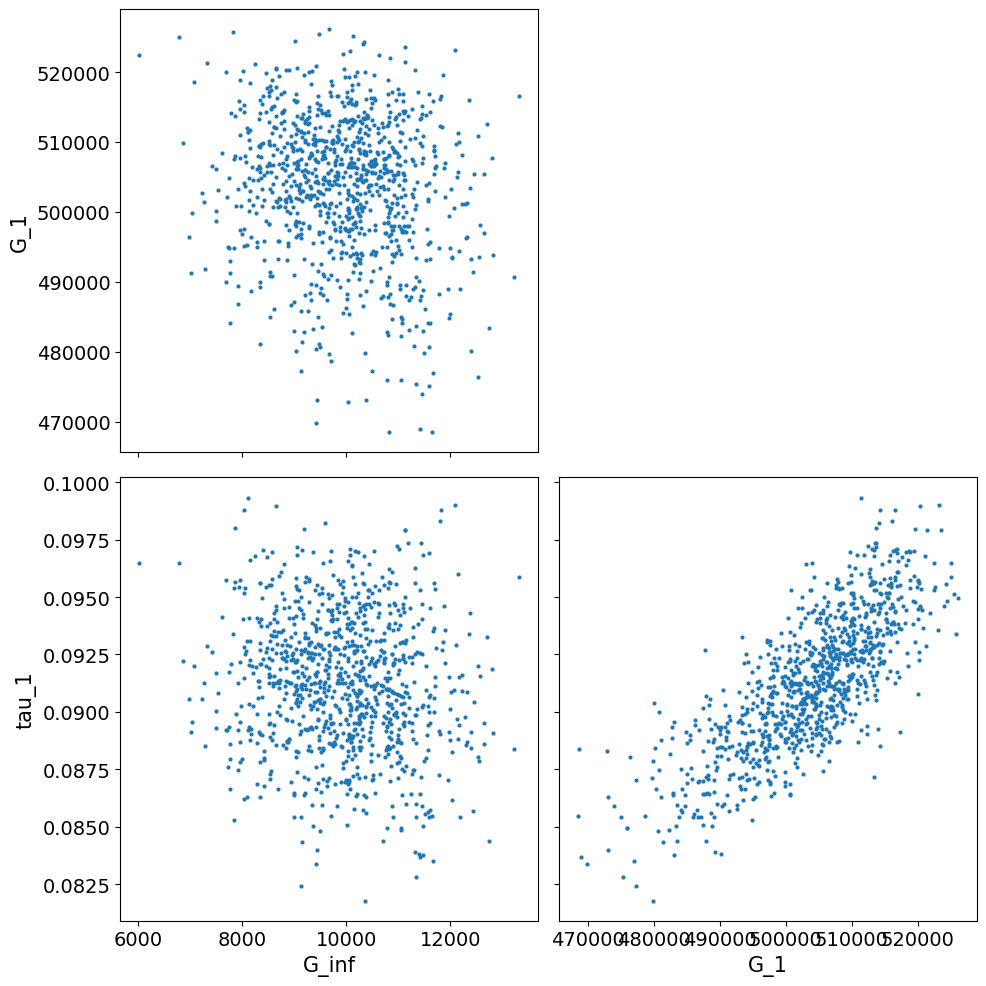

Diagonal: Marginal posterior distributions
Off-diagonal: Joint posteriors (check for correlations)
Red points: Divergences (ideally none or very few)


In [11]:
# Pair plot (parameter correlations)
print("Pair Plot: Posterior Correlations Between Parameters\n")

# Select subset for pair plot (too many params clutters visualization)
pair_vars = ['G_inf', 'G_1', 'tau_1'] if n_opt >= 1 else ['G_inf']

az.plot_pair(idata, var_names=pair_vars, divergences=True, figsize=(10, 10))
plt.tight_layout()
fig = plt.gcf()
display(fig)
plt.close(fig)

print("Diagonal: Marginal posterior distributions")
print("Off-diagonal: Joint posteriors (check for correlations)")
print("Red points: Divergences (ideally none or very few)")

## Part 5: Posterior Predictive Analysis

Posterior Predictive Check: Does model capture data distribution?



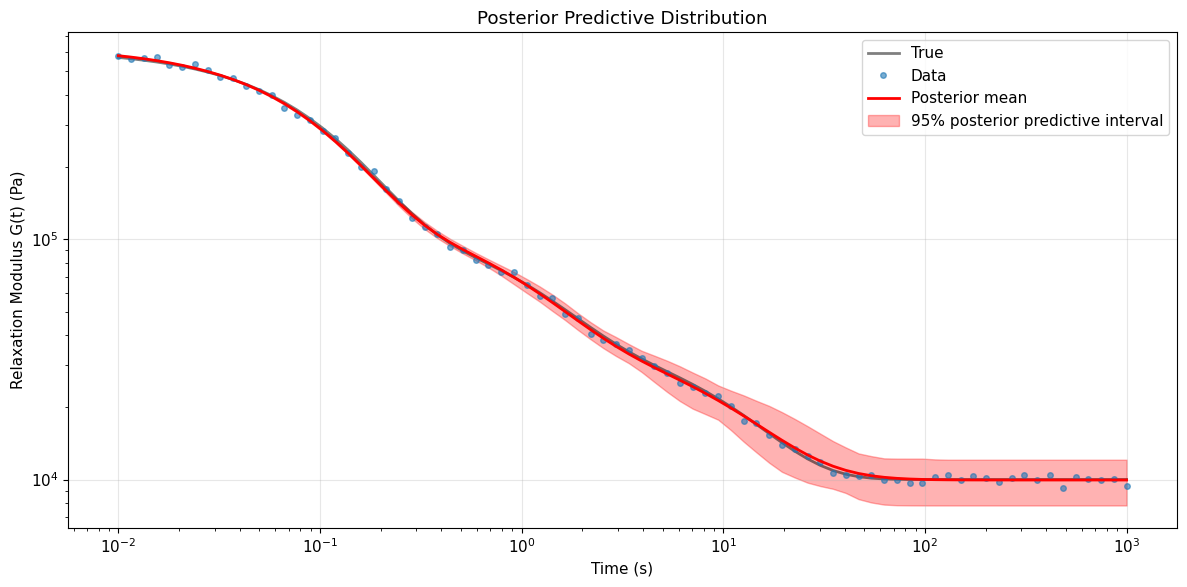

Posterior predictive samples: 100
95% interval captures 77.5% of data points


In [12]:
# Sample from posterior predictive distribution
print("Posterior Predictive Check: Does model capture data distribution?\n")

# Use posterior samples to generate predictions
n_posterior_samples = 100  # Sample 100 parameter sets from posterior
sample_indices = np.random.choice(len(G_inf_posterior), n_posterior_samples, replace=False)

predictions = []
for idx in sample_indices:
    # Set parameters to posterior sample
    gmm.parameters.set_value('G_inf', G_inf_posterior[idx])
    for i in range(1, n_opt + 1):
        gmm.parameters.set_value(f'G_{i}', result.posterior_samples[f'G_{i}'][idx])
        gmm.parameters.set_value(f'tau_{i}', result.posterior_samples[f'tau_{i}'][idx])
    
    # Predict with this parameter set
    predictions.append(gmm.predict(t))

predictions = np.array(predictions)

# Compute prediction intervals
pred_mean = np.mean(predictions, axis=0)
pred_lower = np.percentile(predictions, 2.5, axis=0)
pred_upper = np.percentile(predictions, 97.5, axis=0)

# Plot posterior predictive
fig = plt.figure(figsize=(12, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2, label='True', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, alpha=0.6, label='Data')
plt.loglog(t, pred_mean, 'r-', linewidth=2, label='Posterior mean')
plt.fill_between(t, pred_lower, pred_upper, alpha=0.3, color='red', label='95% posterior predictive interval')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Posterior Predictive Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Posterior predictive samples: {n_posterior_samples}")
print(f"95% interval captures {np.sum((G_t_noisy >= pred_lower) & (G_t_noisy <= pred_upper))/len(t)*100:.1f}% of data points")

## Part 6: Model Comparison (N=1 vs N=3)

Compare Bayesian inference for single-mode (N=1) vs optimized multi-mode (N=3).

Model Comparison: N=1 (single Maxwell) vs N=3 (multi-mode GMM)



Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}
Timer: optimization took 0.227346s
Convergence: reason=`ftol` termination condition is satisfied. | iterations=None | final_cost=1.749267e+10 | time=0.227s | final_gradient_norm=47275746297092.26


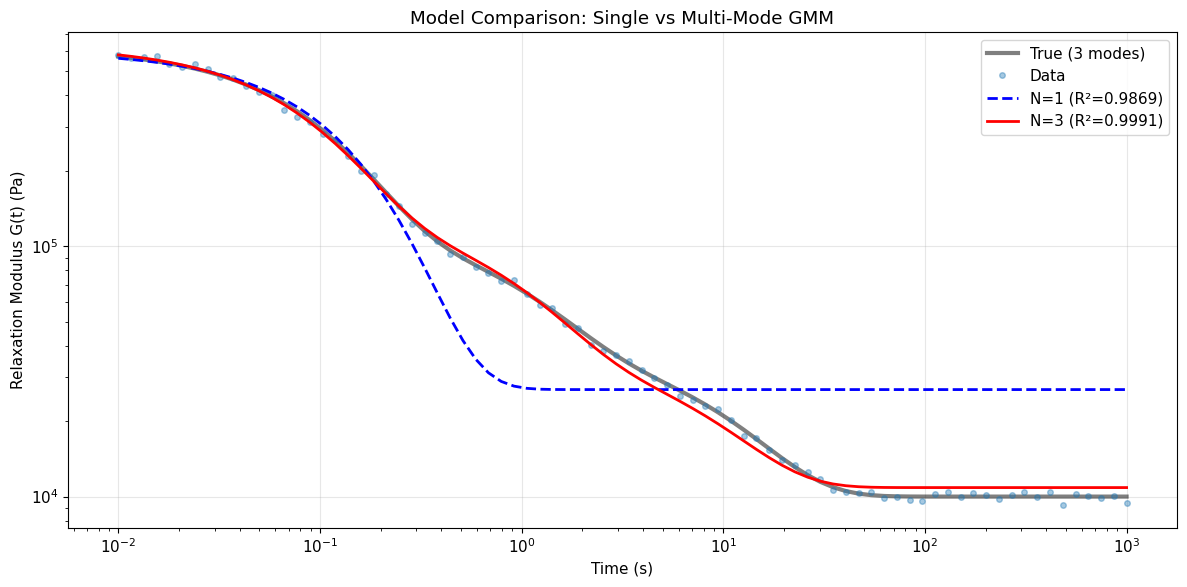

Fit quality comparison:
  N=1: R² = 0.986858
  N=3: R² = 0.999133
  Improvement: 1.23% increase

Multi-mode GMM significantly outperforms single Maxwell


In [13]:
# Fit N=1 model for comparison
print("Model Comparison: N=1 (single Maxwell) vs N=3 (multi-mode GMM)\n")

gmm_n1 = GeneralizedMaxwell(n_modes=1, modulus_type='shear')
gmm_n1.fit(t, G_t_noisy, test_mode='relaxation')

# NLSQ predictions
pred_n1 = gmm_n1.predict(t)
pred_n3 = gmm.predict(t)  # Using N_opt from earlier (should be 3)

# Compute R²
r2_n1 = 1 - np.sum((G_t_noisy - pred_n1)**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)
r2_n3 = 1 - np.sum((G_t_noisy - pred_n3)**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)

# Plot comparison
fig = plt.figure(figsize=(12, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=3, label='True (3 modes)', alpha=0.5)
plt.loglog(t, G_t_noisy, 'o', markersize=4, alpha=0.4, label='Data')
plt.loglog(t, pred_n1, '--', linewidth=2, label=f'N=1 (R²={r2_n1:.4f})', color='blue')
plt.loglog(t, pred_n3, '-', linewidth=2, label=f'N={n_opt} (R²={r2_n3:.4f})', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Relaxation Modulus G(t) (Pa)')
plt.title('Model Comparison: Single vs Multi-Mode GMM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Fit quality comparison:")
print(f"  N=1: R² = {r2_n1:.6f}")
print(f"  N={n_opt}: R² = {r2_n3:.6f}")
print(f"  Improvement: {(r2_n3 - r2_n1)*100:.2f}% increase")
print(f"\nMulti-mode GMM significantly outperforms single Maxwell")

## Interpretation and Insights

### Two-Step Workflow Benefits

1. **NLSQ provides fast point estimates** (seconds to minutes)
2. **NUTS warm-start reduces MCMC time** by 2-5x (fewer warmup iterations needed)
3. **Diagnostics guide prior selection** via tiered safety mechanism
4. **Full uncertainty quantification** through posterior distributions

### Prior Safety Mechanism

- **Prevents misleading posteriors** when NLSQ fails
- **Automatic classification**: hard failure → suspicious → good
- **User control**: `prior_mode='strict'` (fail-fast), `'warn'` (default), `'auto_widen'` (expert)
- **Opt-in fallback**: `allow_fallback_priors=True` for generic weakly informative priors

### Convergence Diagnostics Interpretation

- **R-hat < 1.01**: All chains converged to same posterior (good)
- **ESS > 400**: Sufficient effective samples for reliable estimates
- **Divergences < 1%**: NUTS sampler well-behaved (no pathological geometry)
- **Trace plot 'fuzzy caterpillar'**: Good mixing across parameter space

### Model Comparison Insights

- **N=1 underfits** multi-mode data (low R²)
- **N=3 captures complexity** without overfitting (element minimization prevents N>3)
- **Bayesian uncertainty** quantifies parameter non-identifiability

### When to Use Bayesian GMM

- **Uncertainty quantification** for material properties
- **Model comparison** via posterior predictive checks
- **Parameter correlations** (pair plots reveal identifiability issues)
- **Propagating uncertainty** to downstream predictions

## Key Takeaways

- **Two-Step Workflow:** NLSQ (fast point estimate) → NUTS (warm-started Bayesian inference)
- **Prior Safety:** Tiered mechanism prevents misleading posteriors from bad NLSQ convergence
- **Diagnostics:** R-hat, ESS, divergences ensure reliable posterior estimates
- **Uncertainty Quantification:** Credible intervals and posterior predictive distributions
- **Model Comparison:** Multi-mode GMM significantly outperforms single Maxwell
- **Common Pitfalls:** High divergences → increase `num_warmup`, Low ESS → increase `num_samples`

## Next Steps

- Explore `examples/bayesian/04-model-comparison.ipynb` for formal Bayesian model selection
- Try `examples/bayesian/05-uncertainty-propagation.ipynb` for downstream prediction uncertainty
- Advance to `examples/advanced/08-generalized_maxwell_fitting.ipynb` for frequentist GMM workflows